### Exploratory analysis of the post study questionnaire responses

In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import json 

np.random.seed(42)
sns.set_style('ticks')
sns.set_palette('colorblind')

likert_mapping = {
    'order': ['strongly disagree',  'disagree', 'neutral', 'agree', 'strongly agree'],
    'formatted': ['Strongly Disagree', 'Disagree', 'Neurtal', 'Agree', 'Strongly Agree'],
    'numerical': {
        'strongly disagree': 1, 'disagree': 2, 'neurtal': 3, 'agree': 4, 'strongly agree': 5
    }
}
question_mappings = json.load(open('../data/question_mappings.json', 'r'))

In [67]:
post_study = pd.read_csv('../data/post-study.csv')
post_study.head()

,user_id,user_created,part,choice_satisfaction_one,choice_satisfaction_two,choice_satisfaction_three,choice_satisfaction_four,choice_satisfaction_five,choice_satisfaction_six,choice_satisfaction_seven,...,intention,relevant_one,relevant_two,relevant_three,relevant_four,trust_one,trust_two,trust_three,trust_four,trust_five
0,62b14681-8d4a-44b5-a201-942bba9b4bd8,2022-07-22 13:45:02.013320,part_one,agree,neutral,neutral,agree,neutral,neutral,disagree,...,agree,agree,disagree,agree,agree,disagree,neutral,strongly agree,disagree,agree
1,62b14681-8d4a-44b5-a201-942bba9b4bd8,2022-07-22 13:45:02.013320,part_two,neutral,disagree,neutral,disagree,neutral,disagree,disagree,...,agree,agree,disagree,agree,agree,disagree,neutral,strongly agree,disagree,agree
2,09cf0e31-cf99-47f3-906f-8da336f23f73,2022-07-22 13:45:43.294777,part_one,neutral,neutral,neutral,agree,strongly agree,agree,disagree,...,disagree,disagree,disagree,strongly disagree,strongly disagree,disagree,disagree,agree,disagree,agree
3,09cf0e31-cf99-47f3-906f-8da336f23f73,2022-07-22 13:45:43.294777,part_two,neutral,neutral,neutral,strongly agree,strongly agree,agree,disagree,...,disagree,disagree,disagree,strongly disagree,strongly disagree,disagree,disagree,agree,disagree,agree
4,27405dfe-adee-47e8-b002-818e61c5c552,2022-07-22 14:36:52.999452,part_one,agree,agree,strongly agree,strongly agree,agree,neutral,disagree,...,agree,disagree,disagree,disagree,disagree,strongly disagree,agree,agree,disagree,strongly agree


In [68]:
# literally no idea what happened here
post_study = post_study.rename(columns = {'choice_satisfaction_three.1': 'perceived_effectiveness_three'})
post_study.columns

Index(['user_id', 'user_created', 'part', 'choice_satisfaction_one',
       'choice_satisfaction_two', 'choice_satisfaction_three',
       'choice_satisfaction_four', 'choice_satisfaction_five',
       'choice_satisfaction_six', 'choice_satisfaction_seven',
       'choice_satisfaction_eight', 'choice_satisfaction_nine',
       'perceived_effectiveness_one', 'perceived_effectiveness_two',
       'perceived_effectiveness_three', 'perceived_effectiveness_four',
       'perceived_effectiveness_five', 'perceived_effectiveness_six',
       'perceived_effectiveness_seven', 'perceived_effectiveness_eight',
       'perceived_effectiveness_nine', 'perceived_effectiveness_ten',
       'perceived_quality_one', 'perceived_quality_two',
       'perceived_quality_three', 'perceived_quality_four',
       'perceived_quality_five', 'perceived_quality_six', 'test_awareness_one',
       'test_awareness_two', 'intention', 'relevant_one', 'relevant_two',
       'relevant_three', 'relevant_four', 'trust_one'

In [69]:
questions = {
    q: [x for x in post_study.columns if q in x]
    for q in ['satisfaction', 'effectiveness', 'quality', 'awareness', 'intention', 'relevant', 'trust']
}

In [70]:
users = pd.read_csv('../data/users.csv')
users.columns

Index(['user_id', 'user_created', 'consent', 'art_knowledge', 'museum_visits',
       'view_collections', 'physical_visits', 'condition', 'order', 'age',
       'gender', 'education', 'work', 'disability',
       'distraction_task_timestamp'],
      dtype='object')

In [71]:
"""
This is probably incredibly hacky but it's a way of getting the proper data into
the correct format for later plotting.
"""
import itertools

subdata = []
required_columns = list(itertools.chain.from_iterable([qs for qs in questions.values()]))

for user in users['user_id'].unique():
    if user in post_study['user_id'].unique():
        # which part did the user see the model condition?
        if users[users.user_id == user]['order'].item() == 'model':
            responses = {
                q: post_study[(post_study.user_id == user) & (post_study.part == 'part_one')][q].tolist()[0]
                for q in required_columns
            }
            responses['condition'] = 'model'
            responses['user_id'] = user 
            responses['model_type'] = users[users.user_id == user]['condition'].item()
            subdata.append(responses)
            which = 'part_one'
        else:
            responses = {
                q: post_study[(post_study.user_id == user) & (post_study.part == 'part_two')][q].tolist()[0]
                for q in required_columns
            }
            responses['condition'] = 'random'
            responses['user_id'] = user 
            responses['model_type'] = 'random'
            subdata.append(responses)

        if which == 'part_one':
            responses = {
                q: post_study[(post_study.user_id == user) & (post_study.part == 'part_two')][q].tolist()[0]
                for q in required_columns
            }
            responses['condition'] = 'random'
            responses['user_id'] = user 
            responses['model_type'] = 'random'
            subdata.append(responses)
        else:
            responses = {
                q: post_study[(post_study.user_id == user) & (post_study.part == 'part_one')][q].tolist()[0]
                for q in required_columns
            }
            responses['condition'] = 'model'
            responses['user_id'] = user 
            responses['model_type'] = users[users.user_id == user]['condition'].item()
            subdata.append(responses)

data_formatted = pd.DataFrame(subdata)
        

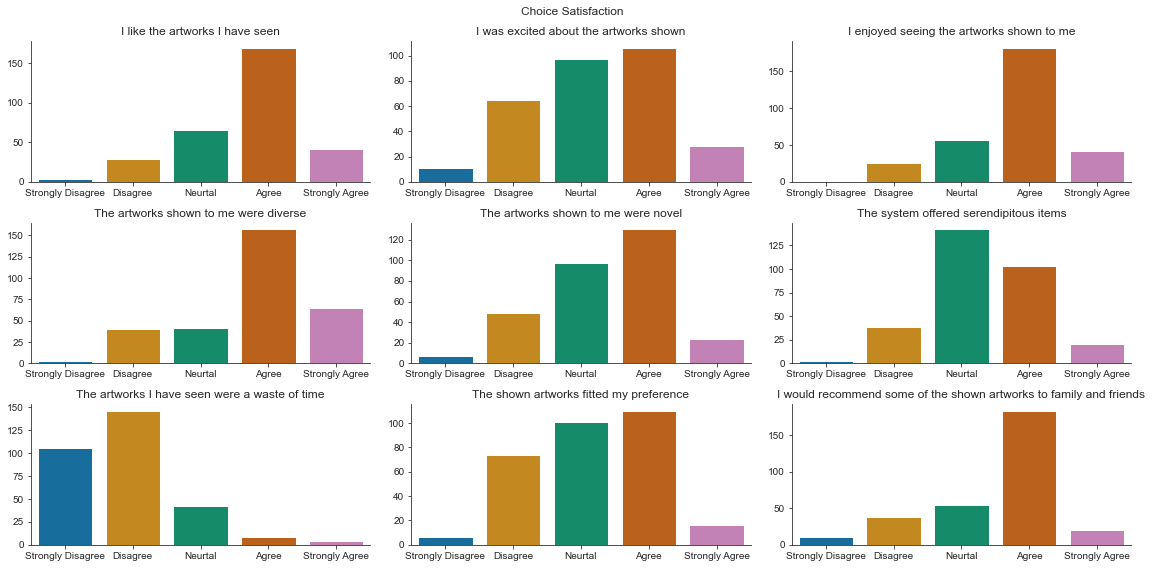

In [72]:
# Create a larger multi-plot for the bigger question groupings, i.e., satisfaction (5x2)
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['satisfaction']):
    p = sns.countplot(
        x = q, data = post_study, ax = ax, 
        order = likert_mapping['order']
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )

fig.suptitle('Choice Satisfaction')
sns.despine()
plt.tight_layout()
# plt.savefig('../plots/post-study/choice_satisfaction.png', dpi = 300)
plt.show()

In [74]:
data_formatted.columns

Index(['choice_satisfaction_one', 'choice_satisfaction_two',
       'choice_satisfaction_three', 'choice_satisfaction_four',
       'choice_satisfaction_five', 'choice_satisfaction_six',
       'choice_satisfaction_seven', 'choice_satisfaction_eight',
       'choice_satisfaction_nine', 'perceived_effectiveness_one',
       'perceived_effectiveness_two', 'perceived_effectiveness_three',
       'perceived_effectiveness_four', 'perceived_effectiveness_five',
       'perceived_effectiveness_six', 'perceived_effectiveness_seven',
       'perceived_effectiveness_eight', 'perceived_effectiveness_nine',
       'perceived_effectiveness_ten', 'perceived_quality_one',
       'perceived_quality_two', 'perceived_quality_three',
       'perceived_quality_four', 'perceived_quality_five',
       'perceived_quality_six', 'test_awareness_one', 'test_awareness_two',
       'intention', 'relevant_one', 'relevant_two', 'relevant_three',
       'relevant_four', 'trust_one', 'trust_two', 'trust_three', 'trus

##### Choice Satisifaction by recommendation type

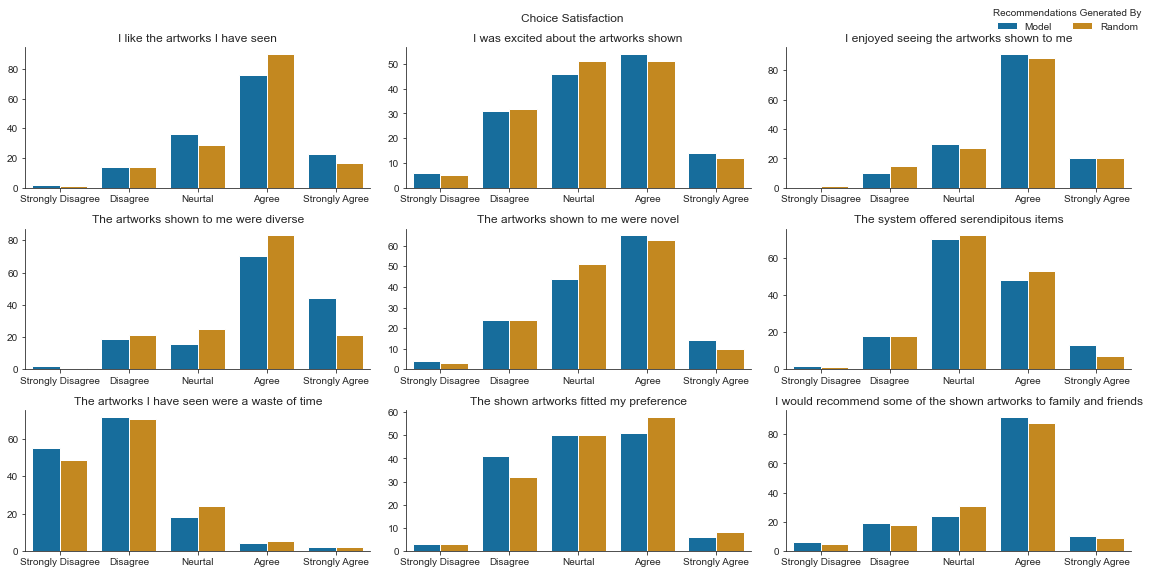

In [82]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['satisfaction']):
    p = sns.countplot(
        x = q, 
        data = data_formatted,
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'condition'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Model', 'Random'], ncol = 2, title = 'Recommendations Generated By', frameon = False)

fig.suptitle('Choice Satisfaction')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('../plots/post-study/choice_satisfaction_by_recs.png', dpi = 300)

##### Perceived effectiveness by recommendation type

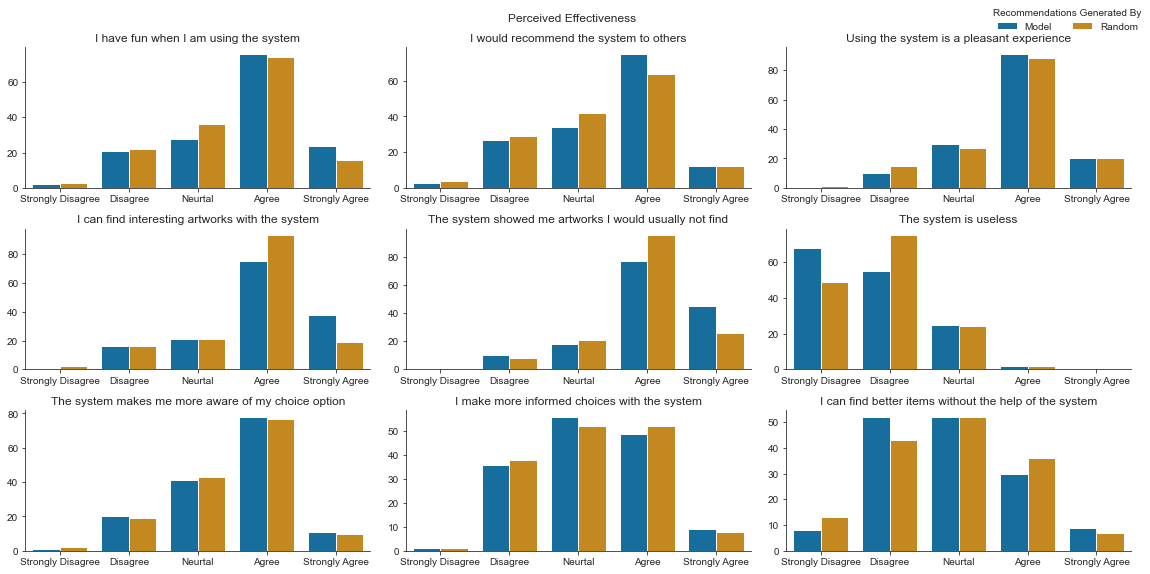

In [84]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['effectiveness']):
    p = sns.countplot(
        x = q, 
        data = data_formatted,
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'condition'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Model', 'Random'], ncol = 2, title = 'Recommendations Generated By', frameon = False)

fig.suptitle('Perceived Effectiveness')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('../plots/post-study/perceived_effectiveness_by_recs.png', dpi = 300)

##### Perceived Quality by recommendation type

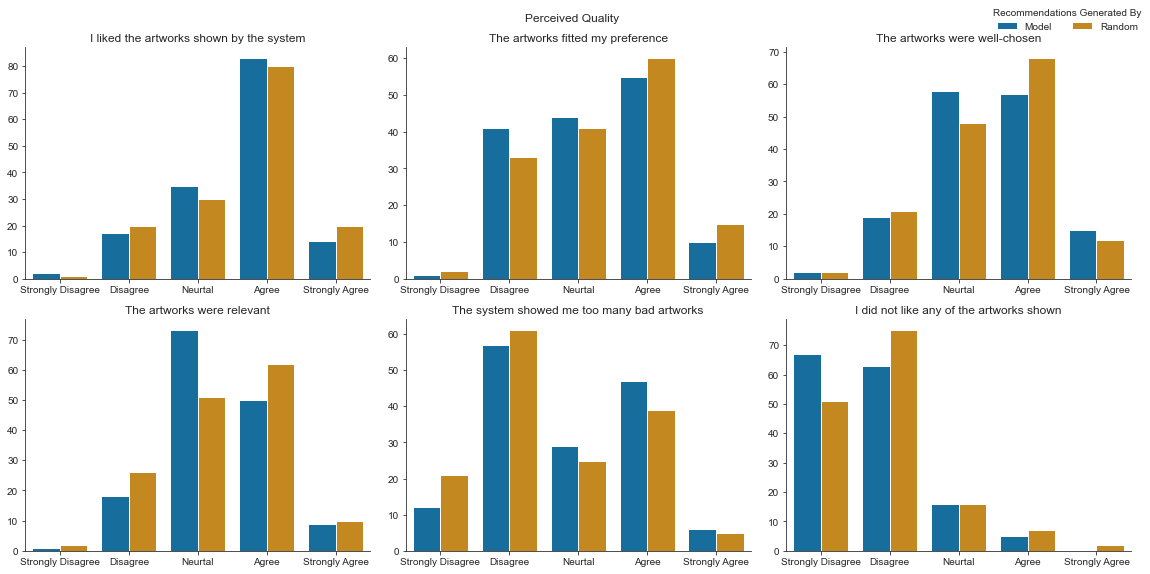

In [89]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 8))
axes = axes.ravel()

for ax, q in zip(axes, questions['quality']):
    p = sns.countplot(
        x = q, 
        data = data_formatted,
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'condition'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Model', 'Random'], ncol = 2, title = 'Recommendations Generated By', frameon = False)

fig.suptitle('Perceived Quality')
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig('../plots/post-study/perceived_quality_by_recs.png', dpi = 300)

##### Test Awareness by recommendation type

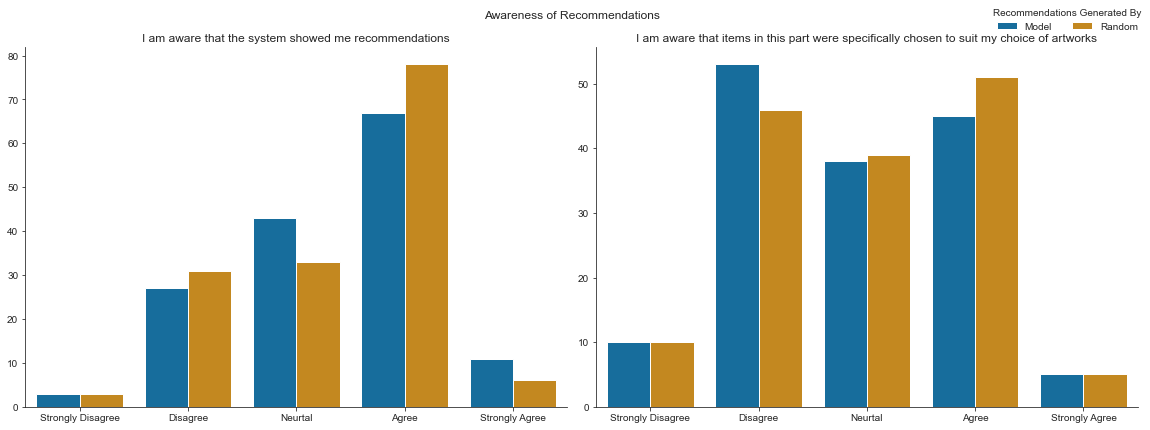

In [95]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
axes = axes.ravel()

for ax, q in zip(axes, questions['awareness']):
    p = sns.countplot(
        x = q, 
        data = data_formatted,
        ax = ax, 
        order = likert_mapping['order'],
        hue = 'condition'
    )
    p.set(
        ylabel = '',
        xlabel = '',
        xticklabels = likert_mapping['formatted'],
        title = question_mappings[q]
    )
    p.legend_.remove()

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Model', 'Random'], ncol = 2, title = 'Recommendations Generated By', frameon = False)

fig.suptitle('Awareness of Recommendations')
sns.despine()
plt.tight_layout()
# plt.show()
plt.savefig('../plots/post-study/test_awareness_by_recs.png', dpi = 300)